In [1]:
from typing import Callable, List, Optional, Iterable
from pathlib import Path
import os
from copy import deepcopy
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing as mp
from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore")

DATA_DIR = "./expt_rslts/"
PICKLE_NAME = "nn_rslts_df.pkl"
IMG_OUTPUT_DIR = Path("imgs/")
IMG_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
TABLE_OUTPUT_DIR = Path("tables/")
TABLE_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

OPT_OF_INTEREST = ("sgd", "kn", "fr", "pr", "hs", "dy", "bfgs")
DISCRIMINATE_FGD = False
if DISCRIMINATE_FGD:
    OPT_OF_INTEREST = ("fgd", "sgd", "kn", "fr", "pr", "hs", "dy", "bfgs")

# Truncate the opts of interest...
OPT_OF_INTEREST = ("sgd", "fr", "bfgs")


DROP_N_EQUALS_TWO = True
DROP_N_LESS_THAN = 10

NAME_DICT = {
    "sgd": "Stochastic Gradient Descent",
    "fgd": "Full Gradient Descent",
    "kn": "Krylov-Newton",
    "fr": "Fletcher-Reeves",
    "pr": "Polak-Ribiere",
    "hs": "Hestenes-Stiefel",
    "dy": "Dai-Yuan",
    "bfgs": "BFGS",
    "bfgsi": "BFGS Inverse",
    "dfp": "Davidon-Fletcher-Powell",
    "dfpi": "Davidon-Fletcher-Powell Inverse",
    "sr1": "Symmetric Rank-One",
    "sr1d": "Symmetric Rank-One Dual",
    "levenberg": "Levenberg"
}

def read_json_to_df(fname):
    try:
        with open(fname) as f:
            tmp_df = pd.json_normalize(json.load(f))
            return tmp_df
    except Exception:
        return None

if not os.path.exists(PICKLE_NAME):
    print("Creating dataframe!")
    assert(os.path.exists(DATA_DIR))
    f_list = glob.glob(os.path.join(DATA_DIR, "TEST_*.json"))
    print("Number of files:", len(f_list))
    with mp.Pool() as p:
        dframes = p.map(read_json_to_df, f_list)
    #dframes = [read_json_to_df(i) for i in f_list]
    dframes = [i for i in dframes if i is not None]
    cifar = pd.concat(dframes)
    cifar.to_pickle(PICKLE_NAME)

else:
    print("Reading dataframe!")
    cifar = pd.read_pickle(PICKLE_NAME)

Reading dataframe!


In [2]:
cifar.keys()

Index(['time', 'train_loss_list', 'test_loss_list', 'test_accuracy_list',
       'train_accuracy_list', 'specs.opt', 'specs.dataset',
       'specs.batch_size_train', 'specs.batch_size_test', 'specs.momentum',
       'specs.hidden', 'specs.max_newton', 'specs.abs_newton_tol',
       'specs.rel_newton_tol', 'specs.max_cr', 'specs.cr_tol',
       'specs.learning_rate', 'specs.sufficient_decrease',
       'specs.curvature_condition', 'specs.extrapolation_factor',
       'specs.max_searches', 'specs.num_epoch', 'specs.seed', 'specs.read_nn',
       'specs.write_nn', 'specs.log_interval', 'specs.device', 'specs.record',
       'specs.memory', 'specs.newton_tol', 'specs.lambda0', 'specs.nu',
       'specs.max_lambda', 'specs.min_lambda', 'specs.initial_radius',
       'specs.max_radius', 'specs.nabla0', 'specs.nabla1', 'specs.nabla2',
       'specs.shrink_factor', 'specs.growth_factor',
       'specs.max_subproblem_iter'],
      dtype='object')

In [3]:
# Data cleaning/preprocessing
cifar["specs.batch_size_train"] = cifar["specs.batch_size_train"].apply(int)
if DISCRIMINATE_FGD:
    cifar.loc[(cifar["specs.opt"] == "sgd") & (cifar["specs.batch_size_train"] >= 50000), "specs.opt"] = "fgd"
    cifar.loc[cifar["specs.opt"] == "fgd"]

cifar = cifar[cifar["specs.opt"].isin(OPT_OF_INTEREST)]

def max_acc_lambda(row):
    try:
        max_ = max(row["test_accuracy_list"])
    except ValueError:
        max_ = 0.0
    return max_

def final_acc_lambda(row):
    try:
        last = row["test_accuracy_list"][-1]
    except IndexError:
        last = float("NaN")
    return last

cumulative_time_lambda = lambda row: np.cumsum(row["time"])

def total_time_lambda(row):
    try:
        max_ = row["training_timestamps"][-1]
    except IndexError:
        max_ = float("NaN")
    return max_

def time_to_peak_lambda(row):
    try:
        max_idx = np.array(row["test_accuracy_list"]).argmax()
        time_to_peak = row["training_timestamps"][max_idx]

    except ValueError:
        time_to_peak = np.inf

    return time_to_peak


def fgd_lambda(row):
    try:
        opt_name = row["specs.opt"]
        batch_size_train = int(row["specs.batch_size_train"])
        if opt_name == "sgd" and batch_size_train >= 50000:
            row["specs.opt"] = "fgd"
    except ValueError:
        print(f"row failed: {row['specs.opt']}")

def debug_lambda(row):
    print(row["training_timestamps"])
    print(row["total_training_time"])
    print(row["time_to_peak_acc"])
    intput("ENTER...")


def apply_lambda(df: pd.DataFrame, colname: str, func: Callable):
    tmp = df.apply(func, axis=1)
    df[colname] = tmp.copy()

    return df

def get_summary_vals(df: pd.DataFrame):
    df = apply_lambda(df, "top_test_acc", max_acc_lambda)
    df = apply_lambda(df, "final_test_acc", final_acc_lambda)
    df = apply_lambda(df, "training_timestamps", cumulative_time_lambda)
    df = apply_lambda(df, "total_training_time", total_time_lambda)
    df = apply_lambda(df, "time_to_peak_acc", time_to_peak_lambda)
    df = df.dropna(subset=["total_training_time"])
    if DROP_N_LESS_THAN is not None:
        df = df[df["specs.batch_size_train"] >= DROP_N_LESS_THAN]

    return df

cifar = get_summary_vals(cifar)
rename_dict = {
    "specs.opt": "Optimizer",
    "specs.batch_size_train": "TrainingBatchSize",
    "top_test_acc": "TopTestAccuracy",
    "time_to_peak_acc": "TimeToPeakAccuracy",
    "total_training_time": "TotalTrainingTime"
}
#cifar.apply(debug_lambda, axis=1)
cifar = cifar.rename(columns=rename_dict)
cifar["TrainingBatchSize"].unique()

array([ 1000, 10000, 50000,    10, 25000,  5000,   100])

In [4]:
#plt.figure()
#plt.plot(cifar["training_timestamps"][0])
cifar["training_timestamps"][0][0]

0    [17.395705825649202, 34.32323835697025, 51.327...
0    [2.8753971548285335, 5.76372953876853, 8.65534...
0    [61.40353347826749, 121.15004569943994, 181.15...
0    [2.325208030641079, 4.6703544072806835, 7.0275...
0    [135.42879216512665, 270.3687202660367, 404.32...
                           ...                        
0    [62.70447641285136, 122.3536382690072, 182.542...
0    [3.1341203388292342, 6.265185500727966, 9.4024...
0    [18.591570084914565, 36.30711786495522, 54.211...
0    [91.90880652703345, 180.5115963940043, 269.354...
0    [70.76612426992506, 141.5513171525672, 212.774...
Name: training_timestamps, Length: 2349, dtype: object

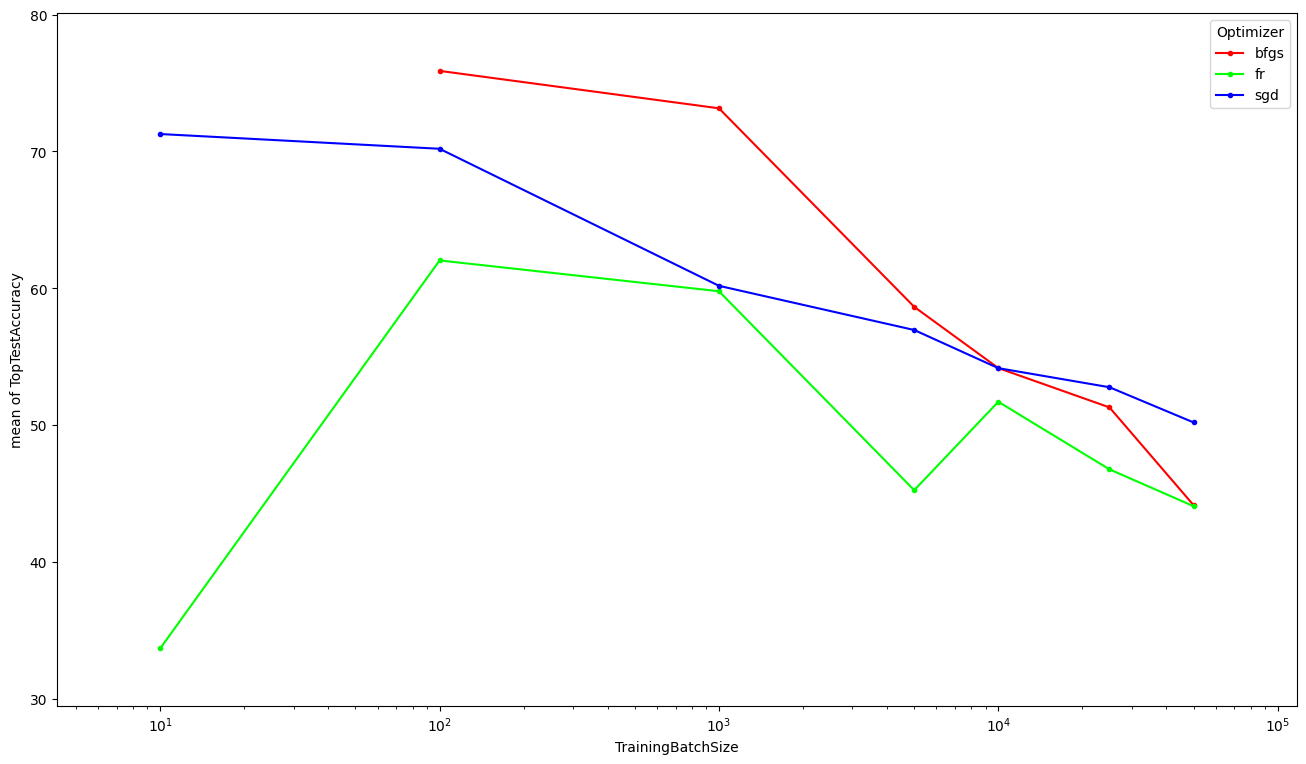

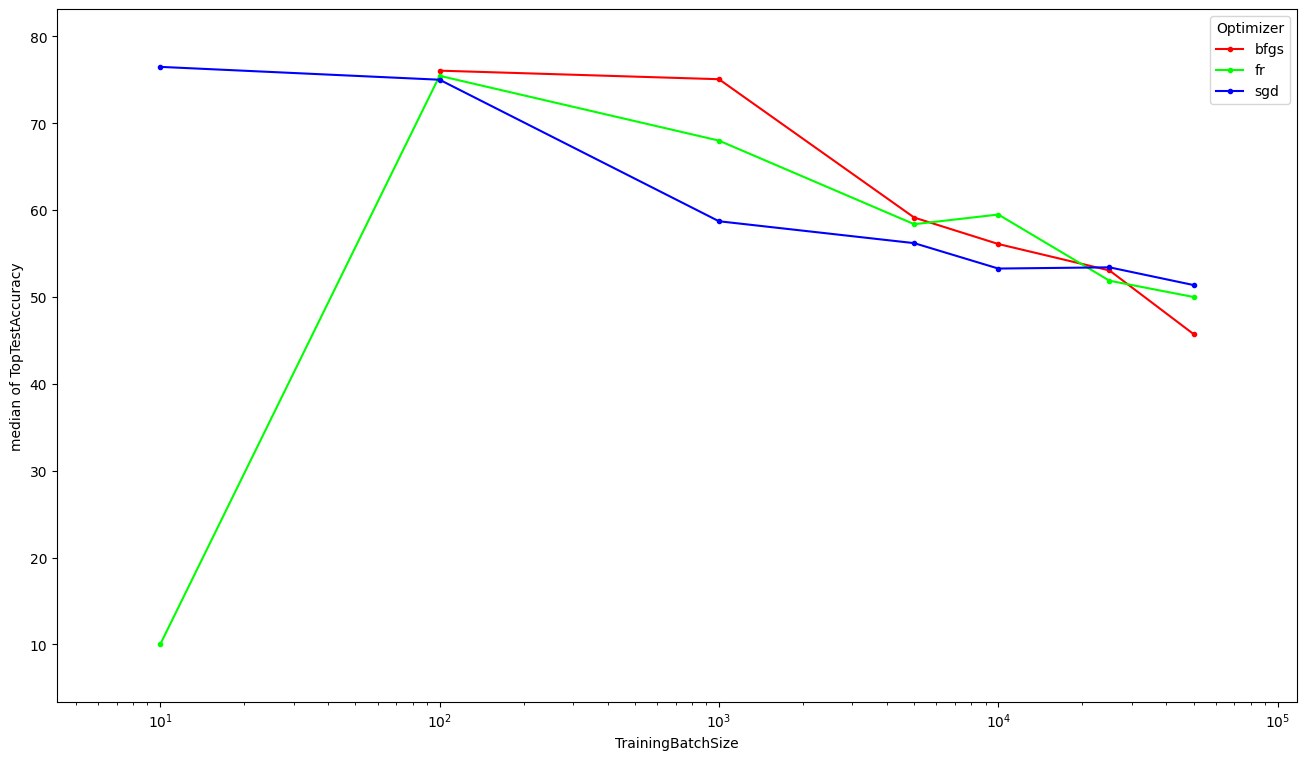

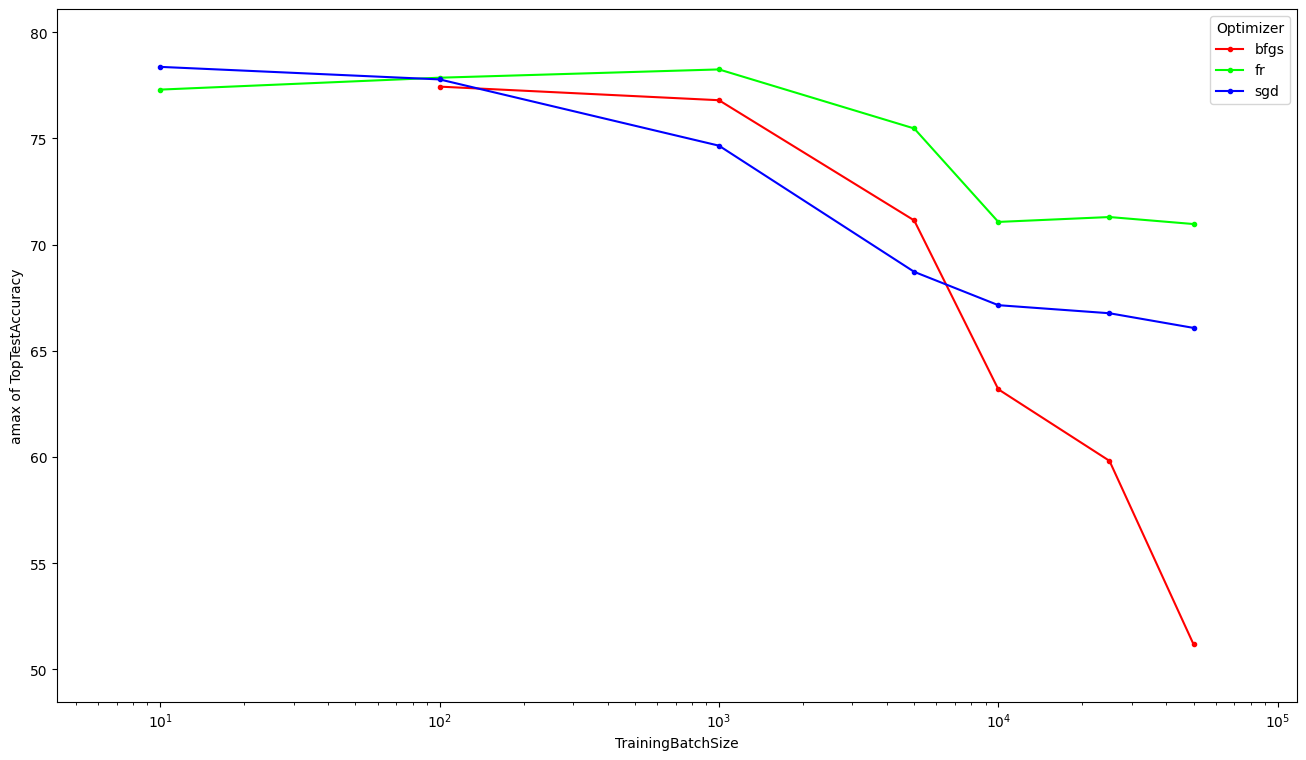

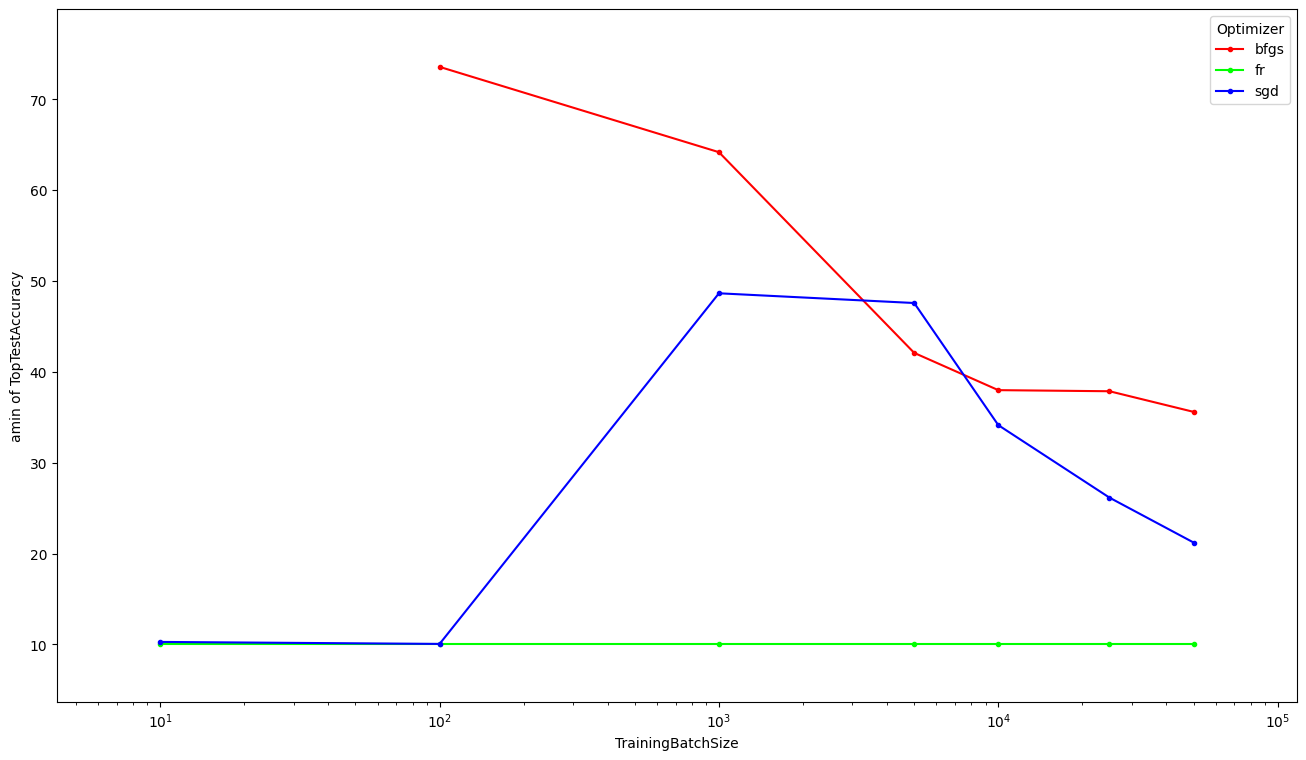

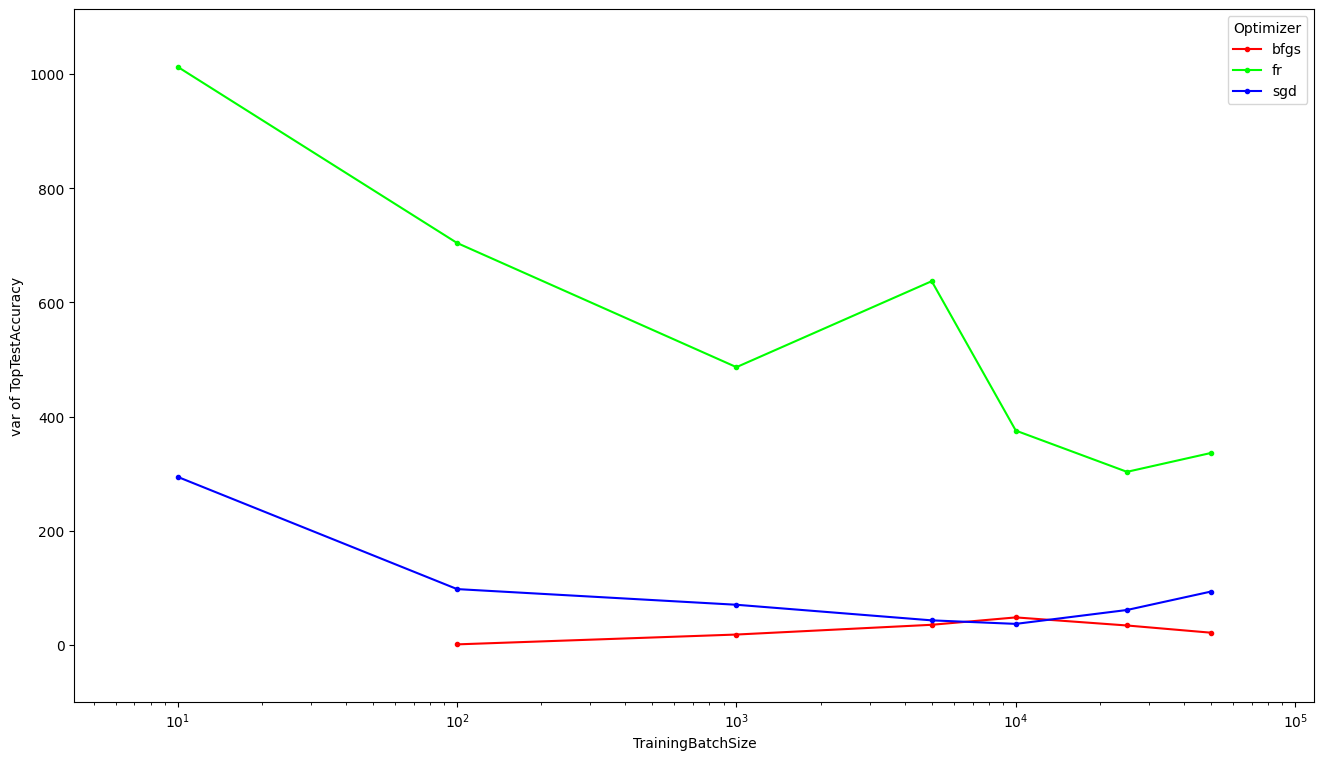

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from scipy import stats 

def my_interaction_plot(df, func, xscale="log"):
    fig, ax = plt.subplots()
    fig.set_figheight(9)
    fig.set_figwidth(16)
    ax.set_xscale(xscale)
    _ = interaction_plot(df["TrainingBatchSize"], df["Optimizer"], df["TopTestAccuracy"], func=func, ax=ax)

my_interaction_plot(cifar, np.mean)
my_interaction_plot(cifar, np.median)
my_interaction_plot(cifar, np.max)
my_interaction_plot(cifar, np.min)
my_interaction_plot(cifar, np.var)



In [6]:
model = ols("TopTestAccuracy ~ C(TrainingBatchSize) + C(Optimizer) + C(TrainingBatchSize):C(Optimizer)", data=cifar).fit()
table = sm.stats.anova_lm(model, typ=2)


In [7]:
table

,sum_sq,df,F,PR(>F)
C(TrainingBatchSize),328881.802355,6.0,218.770690,7.728284e-222
C(Optimizer),42175.644642,2.0,84.165145,5.106051e-36
C(TrainingBatchSize):C(Optimizer),71901.700484,12.0,23.914343,5.111222e-51
Residual,583537.735851,2329.0,NaN,NaN


In [8]:
def dump_data(df: pd.DataFrame, opts_of_interest: Iterable[str], cols: Iterable[str]):
    # Filter on optimizer
    opt_df = df[df["Optimizer"].isin(opts_of_interest)]
    # Subselect rows
    hyperparam_subset = opt_df[cols]
    with open("subselected_data_with_time_info.csv", "w", encoding="UTF-8") as ofile:
        hyperparam_subset.to_csv(ofile, index=False)
    
dump_data(cifar, OPT_OF_INTEREST, ["Optimizer", "TrainingBatchSize", "TopTestAccuracy", "TimeToPeakAccuracy", "TotalTrainingTime"])


In [9]:
with open("subselected_data_with_time_info.csv", "r") as ifile:
    df = pd.read_csv(ifile)

def remove_bad_fr_runs(df_: pd.DataFrame):
    """Handle the weird case of FR failing to train at 5k batch size"""
    return df.loc[~((df["Optimizer"] == "fr") & (df["TopTestAccuracy"] < 15))]

df = remove_bad_fr_runs(df)

In [10]:
df_sgd = df.loc[df["Optimizer"] == "sgd"]
df_fr = df.loc[df["Optimizer"] == "fr"]
df_bfgs = df.loc[df["Optimizer"] == "bfgs"]

MAX_TIME = max([max(df_["TimeToPeakAccuracy"]) for df_ in [df_sgd, df_fr, df_bfgs]])

In [11]:
num_bins = 50
bin_seconds = np.linspace(0, np.log(MAX_TIME), num_bins).flatten()
bin_accuracy = np.linspace(10, 100, num_bins).flatten()
def plot_2d_hist(df_, name):
    plt.figure(figsize=(8,8))
    plt.hist2d(df_["TopTestAccuracy"], np.log(df_["TimeToPeakAccuracy"]), bins=(bin_accuracy, bin_seconds))
    plt.title(f"Peak Accuracy vs. Time to Peak Accuracy, {name}")
    plt.xlabel("Peak Test Accuracy, %")
    plt.ylabel("Time to Peak Accuracy, log(Seconds)")

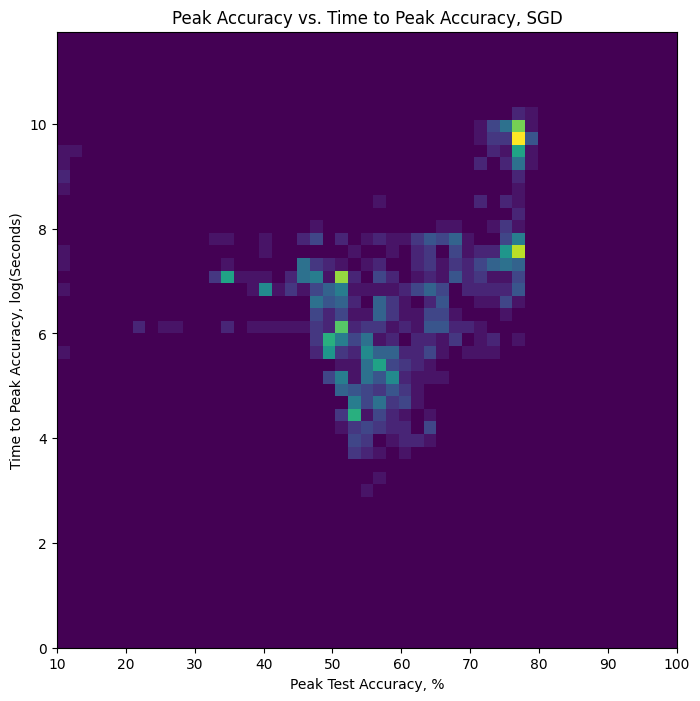

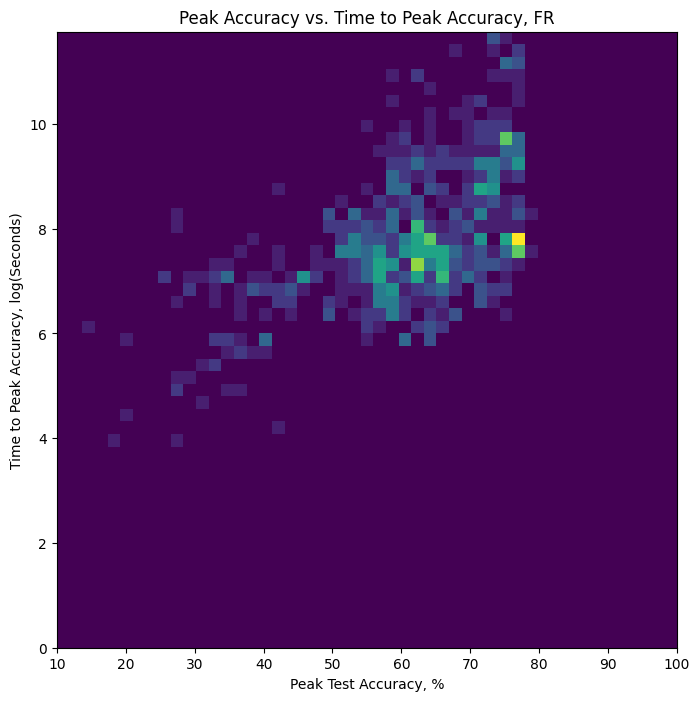

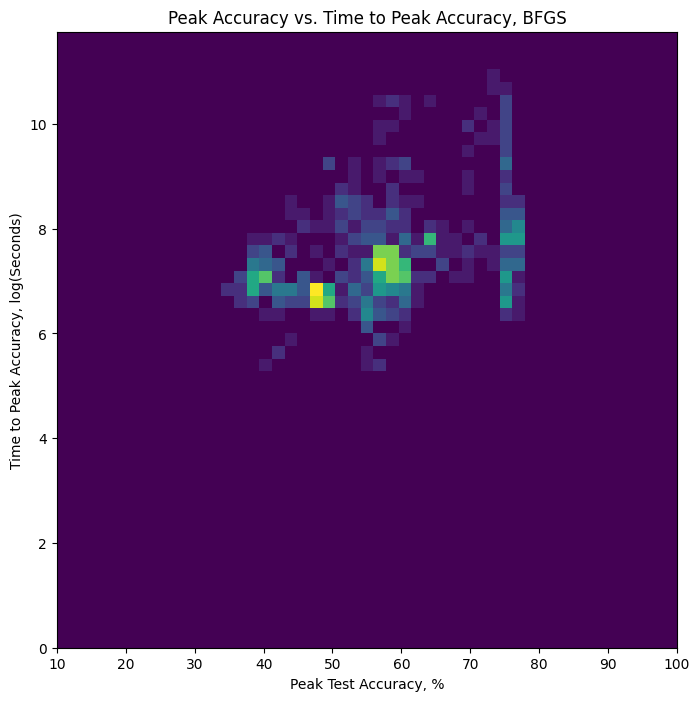

In [12]:
for (df_, name) in [(df_sgd, "SGD"), (df_fr, "FR"), (df_bfgs, "BFGS")]:
    plot_2d_hist(df_, name)

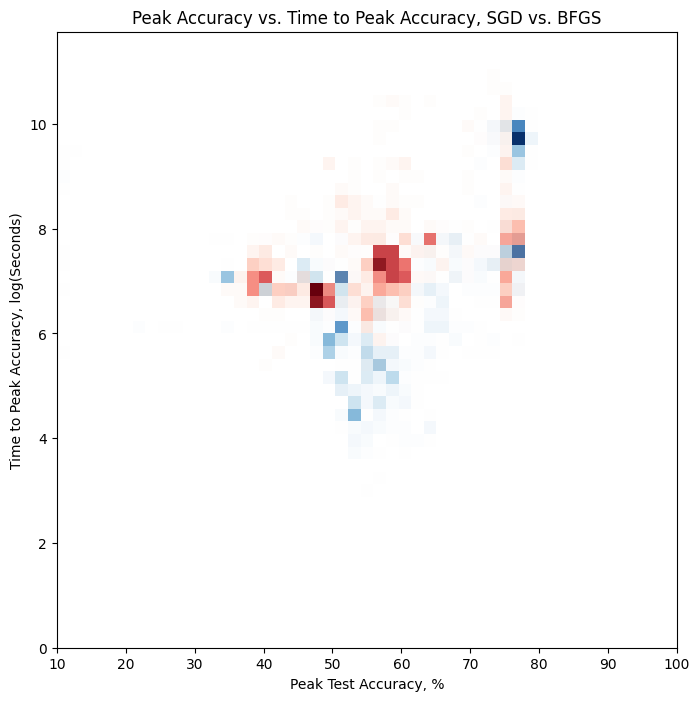

In [13]:
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle

red = pl.cm.Reds
fading_red = red(np.arange(red.N))
fading_red[:, -1] = np.linspace(0, 1, red.N)
fading_red = ListedColormap(fading_red)

blue = pl.cm.Blues
fading_blue = blue(np.arange(blue.N))
fading_blue[:, -1] = np.linspace(0, 1, blue.N)
fading_blue = ListedColormap(fading_blue)
def overlay_2d_hist(df_1, name1, df_2, name2):
    handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in []]
    plt.figure(figsize=(8,8))
    hist1 = plt.hist2d(df_1["TopTestAccuracy"], np.log(df_1["TimeToPeakAccuracy"]), bins=(bin_accuracy, bin_seconds), cmap=fading_blue)
    hist2 = plt.hist2d(df_2["TopTestAccuracy"], np.log(df_2["TimeToPeakAccuracy"]), bins=(bin_accuracy, bin_seconds), cmap=fading_red)
    plt.title(f"Peak Accuracy vs. Time to Peak Accuracy, {name1} vs. {name2}")
    plt.xlabel("Peak Test Accuracy, %")
    plt.ylabel("Time to Peak Accuracy, log(Seconds)")

overlay_2d_hist(df_sgd, "SGD", df_bfgs, "BFGS")